<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

In [1]:
# Importations des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime as dt
import pingouin as pingouin 
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [2]:
#Importations csv
products = pd.read_csv("C:/Users/AUCLAIR/Documents/Projet_Data_9/products.csv", sep=';')
transactions = pd.read_csv("C:/Users/AUCLAIR/Documents/Projet_Data_9/transactions.csv", sep=';')
customers = pd.read_csv("C:/Users/AUCLAIR/Documents/Projet_Data_9/customers.csv", sep=';')

C:\Users\AUCLAIR\AppData\Local\Temp\ipykernel_13832\187459473.py:3: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions = pd.read_csv("C:/Users/AUCLAIR/Documents/Projet_Data_9/transactions.csv", sep=';')


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse exploratoire des fichiers</h2>
</div>

**Analyse de products:**

In [3]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [4]:
products.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [5]:
doublons= products.duplicated(subset="id_prod")
products[doublons]

,id_prod,price,categ


In [6]:
products.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [7]:
products.describe()

,price,categ
count,3286.000000,3286.000000
mean,21.863597,0.370359
std,29.849786,0.615446
min,0.620000,0.000000
25%,6.990000,0.000000
50%,13.075000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [8]:
#Analyse catégories  des produits
products["categ"].unique()

array([0, 1, 2])

**Analyse de transactions:**

In [9]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033


In [10]:
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

In [11]:
transactions.isna().sum()

id_prod       361041
date          361041
session_id    361041
client_id     361041
dtype: int64

In [12]:
len(transactions)

1048575

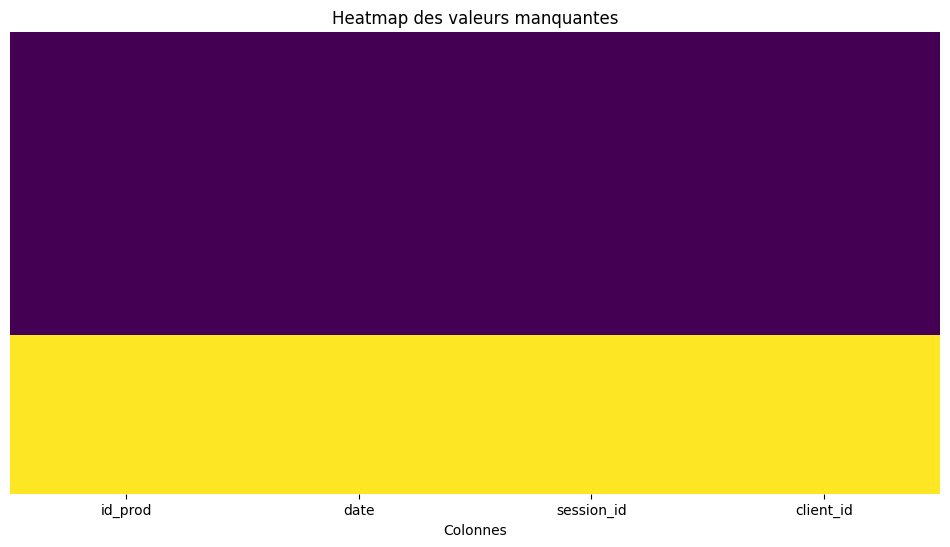

In [13]:
# Heatmap pour visualiser les valeurs manquantes
plt.figure(figsize=(12, 6))
sns.heatmap(
    transactions.isnull(),                 # True là où c’est manquant
    cbar=False,                  # cache la barre de couleur
    cmap='viridis',             # ou 'magma', 'Greys', …
    yticklabels=False            # pour des tables larges : évite le chevauchement
)
plt.title('Heatmap des valeurs manquantes')
plt.xlabel('Colonnes')
plt.show()

In [14]:
transactions[transactions.isna()]

,id_prod,date,session_id,client_id
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
1048570,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaN,NaN
1048572,NaN,NaN,NaN,NaN
1048573,NaN,NaN,NaN,NaN


In [15]:
transactions_NAN = transactions.isna().all(axis=1)
transactions = transactions[~transactions_NAN]
len(transactions)

687534

In [16]:
transactions.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [17]:
#Analyse de la colonne 'date'
transactions['date'] = pd.to_datetime(transactions['date'])
doublons_dates = transactions.duplicated(subset = "date", keep=False)
transactions[doublons_dates]

,id_prod,date,session_id,client_id
197076,1_414,2021-10-02 01:17:27.925296,s_107282,c_70
197077,1_651,2021-10-02 01:17:27.925296,s_107282,c_70
197086,1_311,2021-10-02 01:23:55.310730,s_100028,c_5723
197087,1_495,2021-10-02 01:23:55.310730,s_100028,c_5723
197129,1_288,2021-10-02 02:16:39.453765,s_102820,c_1970
...,...,...,...,...
217993,1_293,2021-10-22 22:28:58.194395,s_109098,c_7272
219528,1_462,2021-10-24 21:11:54.305246,s_101347,c_711
219529,1_245,2021-10-24 21:11:54.305246,s_101347,c_711
220141,1_157,2021-10-25 17:06:59.656670,s_101176,c_436


In [18]:
# on valide pour pour une même session_id, il peut y avoir, plusiseurs dates 
session_date_counts = transactions.groupby('session_id')['date'].nunique()

# Filtrer ceux qui ont plus d'une date
sessions_multi_dates = session_date_counts[session_date_counts > 1]

# Afficher les sessions concernées
print(sessions_multi_dates)

session_id
s_100       2
s_1000      4
s_10000     3
s_100001    2
s_100002    2
           ..
s_99992     2
s_99994     3
s_99996     4
s_99998     3
s_99999     3
Name: date, Length: 181182, dtype: int64


**Je remarque plus d'une centaine de doublons sur la colonne date.**

In [19]:
# Période des doublons de date
doublons_octobre_21 = transactions[doublons_dates]
doublons_octobre_21['date'].min(), doublons_octobre_21['date'].max()

(Timestamp('2021-10-02 01:17:27.925296'),
 Timestamp('2021-10-25 17:06:59.656670'))

In [20]:
# Recherche de la nature des doublons
doublons_octobre_21 = transactions[doublons_dates]
grouped = doublons_octobre_21.groupby(['session_id', 'client_id'])
duplicated_rows = grouped.filter(lambda x: x['id_prod'].duplicated().any())
print(duplicated_rows.sort_values(by=['session_id', 'client_id', 'id_prod']))

Empty DataFrame
Columns: [id_prod, date, session_id, client_id]
Index: []


In [21]:
#Nombre de transactions
nb_transactions = transactions.drop_duplicates(subset=['session_id', 'client_id', 'date']).shape[0]
nb_transactions

687415

In [22]:
# Nombre de produits vendus
len(transactions)

687534

In [23]:
transactions['date'].describe()

count                           687534
mean     2022-03-01 21:24:00.618519296
min         2021-03-01 00:01:07.843138
25%      2021-09-10 10:35:20.642323456
50%      2022-02-27 06:50:25.400120064
75%      2022-08-28 22:16:49.841665536
max         2023-02-28 23:58:30.792755
Name: date, dtype: object

In [24]:
# Range des dates
print(transactions['date'].min(), transactions['date'].max())

2021-03-01 00:01:07.843138 2023-02-28 23:58:30.792755


**Analyse de customers:**

In [25]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [26]:
# Vérification des valeurs manquantes
customers.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [27]:
doublons_customers = customers.isna().all(axis=1)
customers[doublons_customers]

,client_id,sex,birth


In [28]:
customers.dtypes

client_id    object
sex          object
birth         int64
dtype: object

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Jonction des fichiers</h2>
</div>

**Jointures**

In [29]:
len(products), len(customers), len(transactions)

(3286, 8621, 687534)

In [30]:
df_merge = products.merge(transactions, on = 'id_prod')
df_merge.isna().sum()

id_prod       0
price         0
categ         0
date          0
session_id    0
client_id     0
dtype: int64

In [31]:
df_data = df_merge.merge(customers, on ="client_id")
df_data.isna().sum()

id_prod       0
price         0
categ         0
date          0
session_id    0
client_id     0
sex           0
birth         0
dtype: int64

In [32]:
len(df_data)

687534

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Analyses graphiques</h2>
</div>

**ANALYSES :**

In [33]:
df_data.head()

,id_prod,price,categ,date,session_id,client_id,sex,birth
0,0_1421,19.99,0,2021-03-01 04:13:00.107748,s_101,c_8533,m,1972
1,0_1421,19.99,0,2021-03-01 13:48:20.214075,s_285,c_5299,f,1967
2,0_1421,19.99,0,2021-03-01 15:07:42.730079,s_317,c_8024,f,1936
3,0_1421,19.99,0,2021-03-02 03:39:21.811833,s_563,c_7702,f,1989
4,0_1421,19.99,0,2021-03-02 19:09:41.789425,s_850,c_4057,m,1981


In [34]:
# Chiffre d’affaires journalier et moyenne mobile (7 jours)
df_daily_sales = df_data.groupby(df_data['date'].dt.date)['price'].sum().reset_index()
df_daily_sales.rename(columns={'date': 'day', 'price': 'revenue'}, inplace=True)
df_daily_sales = df_daily_sales.sort_values('day')
df_daily_sales['revenue_rolling'] = df_daily_sales['revenue'].rolling(window=7).mean()


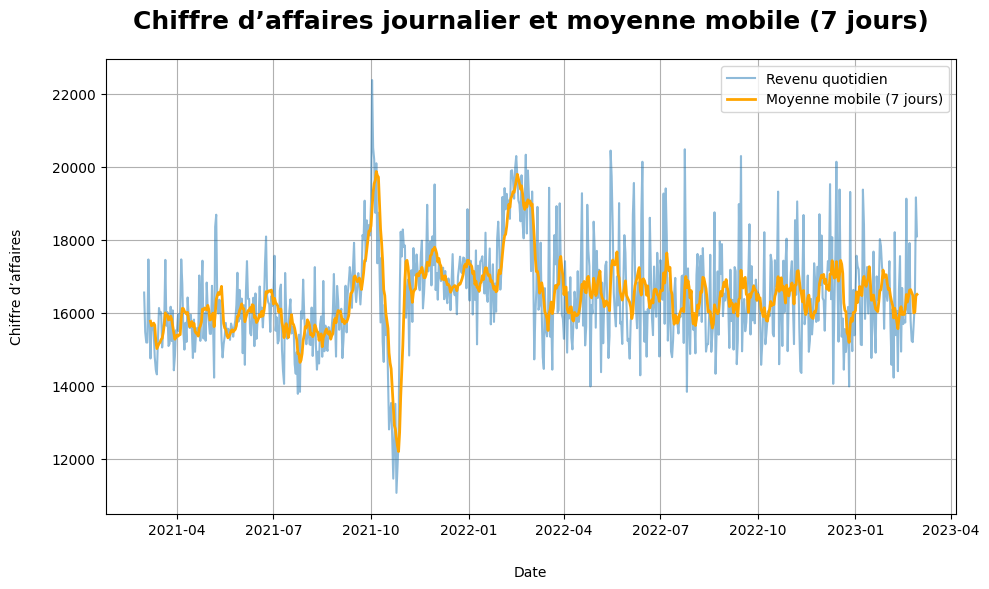

In [35]:
# Graphique du Chiffre d’affaires journalier et moyenne mobile (7 jours)
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_daily_sales, x="day", y="revenue", label="Revenu quotidien", alpha=0.5)
sns.lineplot(data=df_daily_sales, x="day", y="revenue_rolling", 
             label="Moyenne mobile (7 jours)", color='orange', linewidth=2)

plt.title("Chiffre d’affaires journalier et moyenne mobile (7 jours)", y =1.05, fontsize=18, fontweight='bold')
plt.xlabel("Date", labelpad=20)
plt.ylabel("Chiffre d’affaires", labelpad=20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Évolution des achats par catégorie dans le temps
df_grouped = df_data.groupby([df_data['date'].dt.date, 'categ']).size().reset_index(name='count')

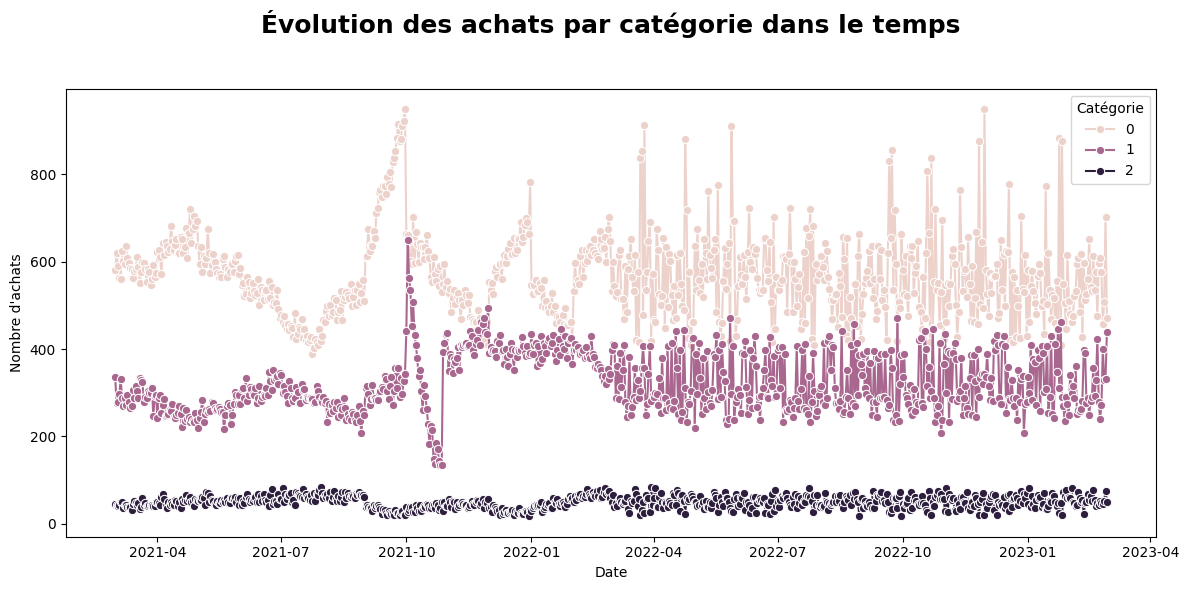

In [37]:
# Graphique de l'Évolution des achats par catégorie dans le temps
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x='date', y='count', hue='categ', marker='o')

plt.title('Évolution des achats par catégorie dans le temps', pad=40, size=18, weight = "bold")
plt.xlabel('Date')
plt.ylabel('Nombre d\'achats')
plt.legend(title='Catégorie')
plt.tight_layout()

plt.show()

In [38]:
#Chiffre d'affaire par catégorie
CA_categories = df_data.groupby('categ')[["price"]].sum()
CA_categories

,price
categ,
0,4419730.97
1,4827657.11
2,2780275.02


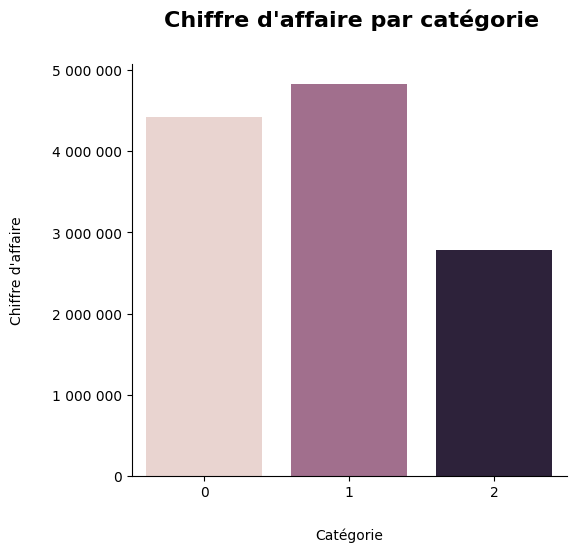

In [39]:
#Graphique du chiffre d'affaire par catégorie
g = sns.catplot(data = CA_categories, kind= 'bar', x='categ', y = 'price', hue='categ')
g._legend.remove()
g.fig.suptitle("Chiffre d'affaire par catégorie", y=1.05, fontsize= 16, fontweight = 'bold')
g.ax.set_xlabel("Catégorie", labelpad=20)
g.ax.set_ylabel("Chiffre d'affaire", labelpad=20)
g.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))
plt.show()

In [40]:
# Evolution du chiffre d'affaire par mois et par catégories
df_data['mois'] = df_data['date'].dt.to_period('M').dt.to_timestamp()
CA_par_mois_par_categories = df_data.groupby(['mois', 'categ'])['price'].sum().reset_index()
CA_par_mois_par_categories

,mois,categ,price
0,2021-03-01,0,193629.17
1,2021-03-01,1,186974.17
2,2021-03-01,2,101837.27
3,2021-04-01,0,205222.46
4,2021-04-01,1,156138.35
...,...,...,...
67,2023-01-01,1,210104.41
68,2023-01-01,2,126153.08
69,2023-02-01,0,162457.00
70,2023-02-01,1,180347.24


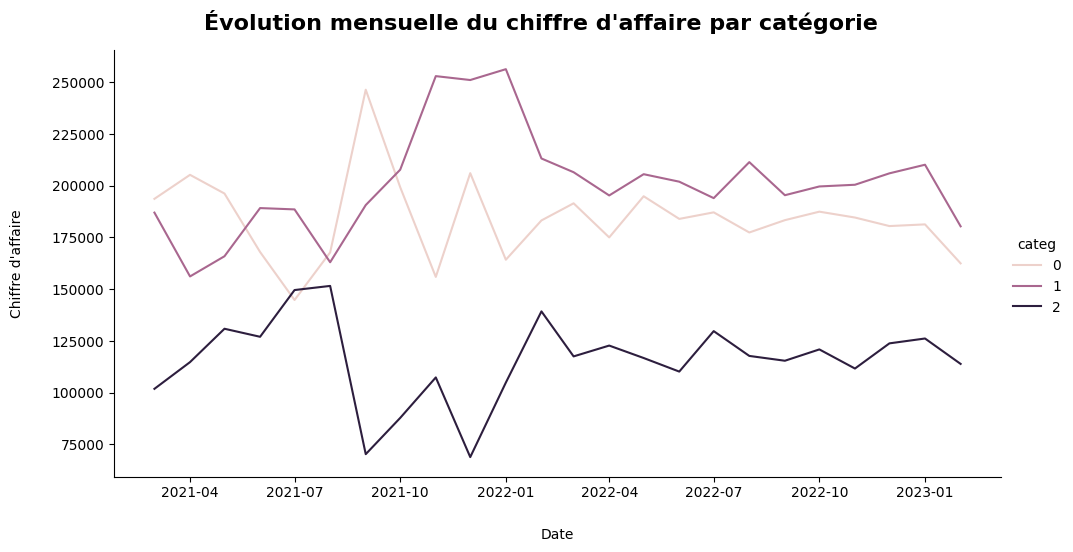

In [41]:
# Graphique de l'Evolution du chiffre d'affaire par mois
g = sns.relplot(data = CA_par_mois_par_categories,  x = 'mois', y = 'price', hue='categ', kind= 'line', aspect=2)
g.fig.suptitle("Évolution mensuelle du chiffre d'affaire par catégorie", y=1.05, fontsize= 16, fontweight = 'bold')
g.ax.set_xlabel("Date", labelpad=20)
g.ax.set_ylabel("Chiffre d'affaire", labelpad=20)
plt.show()

In [42]:
# Nombre de clients uniques par mois
clients_par_mois= df_data.resample("ME", on="date")[["client_id"]].nunique()

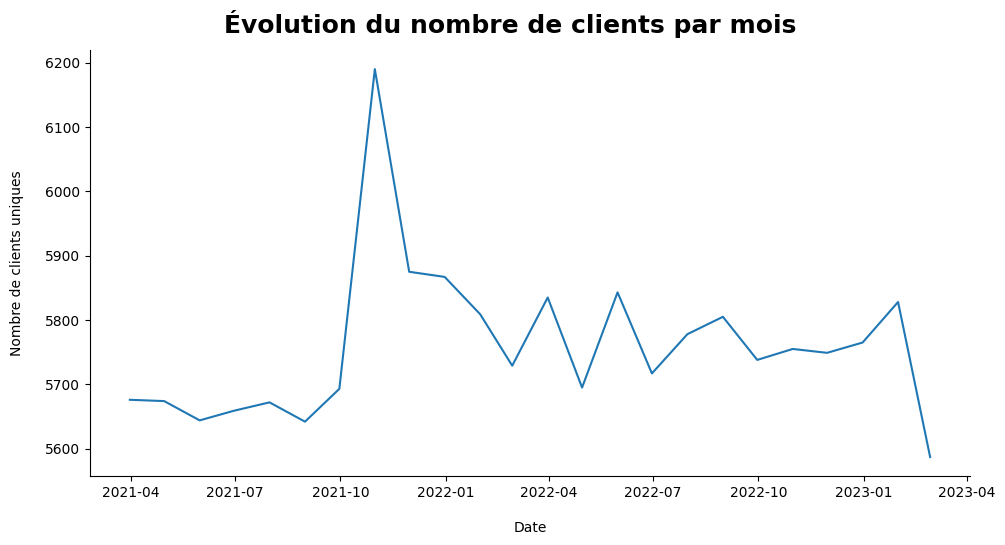

In [43]:
# Graphique du nombre de clients uniques par mois
g = sns.relplot(data = clients_par_mois, x='date', y = "client_id", kind ='line', aspect=2)
g.fig.suptitle("Évolution du nombre de clients par mois", y = 1.05, fontsize = 18, fontweight = 'bold')
g.ax.set_xlabel("Date", labelpad=15)  
g.ax.set_ylabel("Nombre de clients uniques", labelpad=15)  
plt.show()

In [44]:
# Nombre de transactions par mois
df_data_2 = df_data.set_index('date')
transactions_par_mois = df_data_2.resample('ME').size().reset_index(name='nb_transactions')

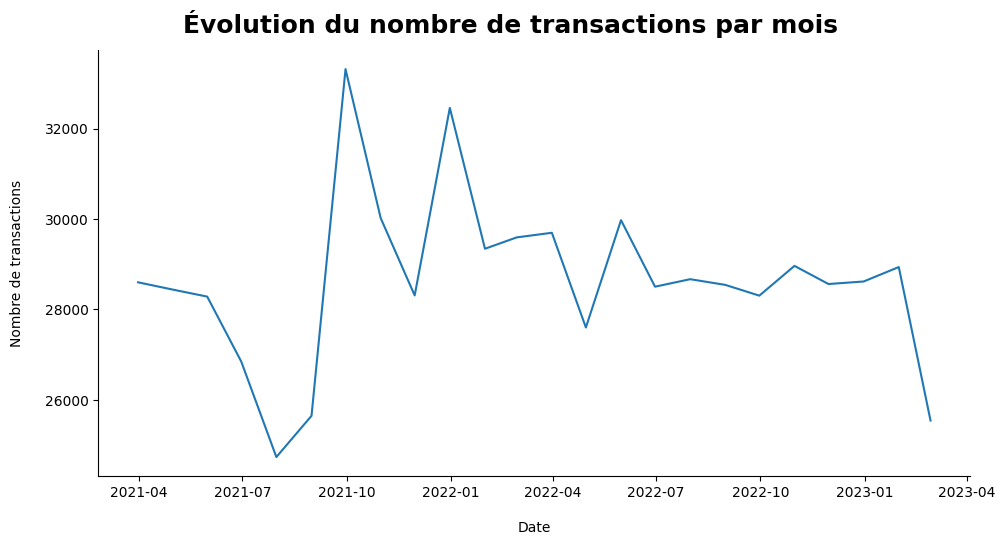

In [45]:
# Graphique du Nombre de transactions par mois
g = sns.relplot(data= transactions_par_mois, x ='date', y = 'nb_transactions', kind = 'line', aspect=2)
g.fig.suptitle("Évolution du nombre de transactions par mois", y =1.05, fontsize = 18, fontweight = 'bold')
g.ax.set_xlabel("Date", labelpad=15)  
g.ax.set_ylabel('Nombre de transactions', labelpad=15) 
plt.show()

**LES TOP 20**

In [46]:
# Top 20 des clients qui ont le plus achetés
top_clients_count = df_data['client_id'].value_counts().head(20).reset_index()
top_clients_count.columns = ['client_id', 'nb_achats']
top_clients_count

,client_id,nb_achats
0,c_1609,25586
1,c_6714,9199
2,c_3454,6793
3,c_4958,5222
4,c_2140,405
5,c_3263,403
6,c_2595,398
7,c_2077,386
8,c_1637,384
9,c_7421,381


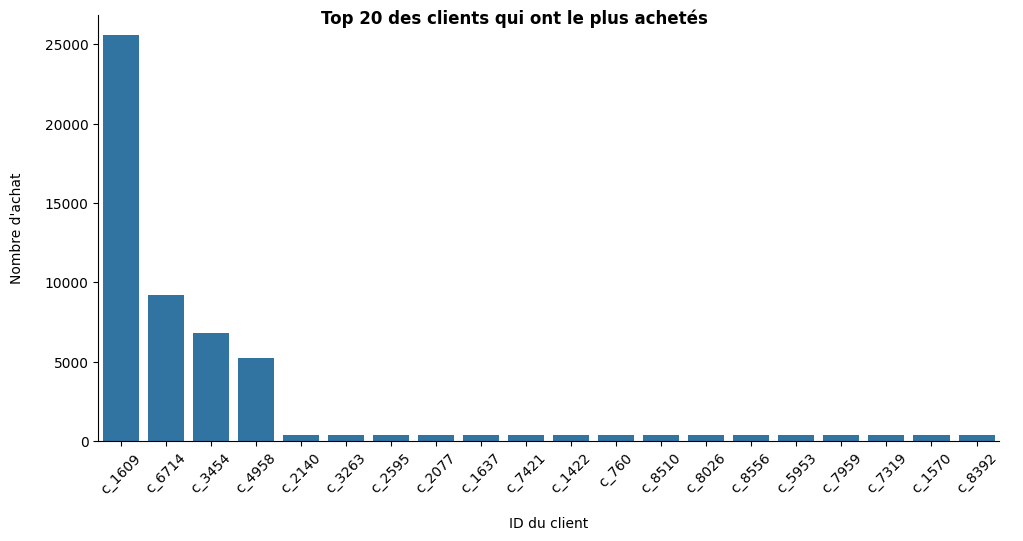

In [47]:
#Graphique Top 20 des clients qui ont le plus achetés
g = sns.catplot(data = top_clients_count, x ='client_id', y = "nb_achats", kind= 'bar', aspect = 2)
g.fig.suptitle("Top 20 des clients qui ont le plus achetés", fontweight = 'bold')
g.ax.set_xlabel("ID du client", labelpad=15)  
g.ax.set_ylabel("Nombre d'achat", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

In [48]:
# Top 20 des clients qui ont le plus générés de chiffres d'affaire
top_clients_CA = df_data.groupby('client_id')['price'].sum().sort_values(ascending=False).head(20).reset_index()
top_clients_CA.columns = ['client_id', 'total_revenue']
top_clients_CA

,client_id,total_revenue
0,c_1609,326039.89
1,c_4958,290227.03
2,c_6714,153918.60
3,c_3454,114110.57
4,c_1570,5285.82
5,c_3263,5276.87
6,c_2140,5260.18
7,c_2899,5214.05
8,c_7319,5155.77
9,c_7959,5135.75


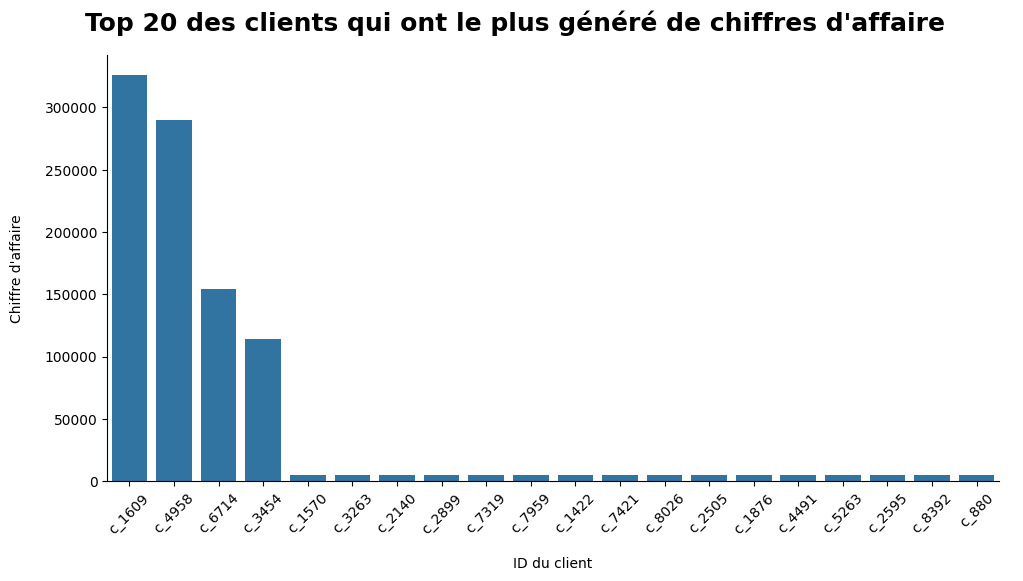

In [49]:
#Grapgique Top 20 des clients qui ont le plus généré de chiffres d'affaire
g = sns.catplot(data = top_clients_CA, x = "client_id", y = "total_revenue", kind = "bar", aspect= 2)
g.fig.suptitle("Top 20 des clients qui ont le plus généré de chiffres d'affaire",
               y=1.06, fontsize = 18, fontweight = 'bold')
g.ax.set_xlabel("ID du client", labelpad=15)  
g.ax.set_ylabel("Chiffre d'affaire", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

**Analyse sur les produits :**

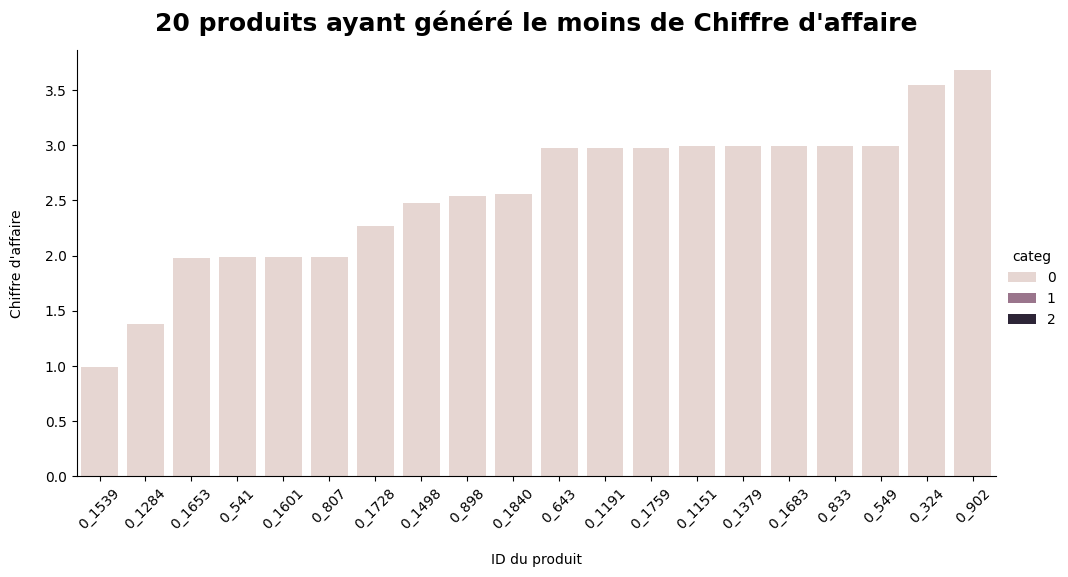

In [50]:
# FLOP 20 Produits qui ont le moins générés de Chiffre d'affaire

flop_20 = df_data.groupby(['id_prod', 'categ'])[['price']].sum()
flop_20 = flop_20.sort_values('price').head(20).reset_index()

#Visualisasion
categs = sorted(df_data['categ'].unique()) 
palette = {0: '#e9d4cf', 1: '#a06f8d', 2: '#2d223a'}
flop_20 ['categ'] = pd.Categorical(flop_20 ['categ'], categories=categs)

g = sns.catplot(data = flop_20, x= 'id_prod', y = 'price', hue='categ', kind = 'bar', aspect= 2, palette = palette)
g.fig.suptitle("20 produits ayant généré le moins de Chiffre d'affaire", y= 1.05, fontsize=18, fontweight='bold')
g.ax.set_xlabel("ID du produit", labelpad=15)  
g.ax.set_ylabel("Chiffre d'affaire", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

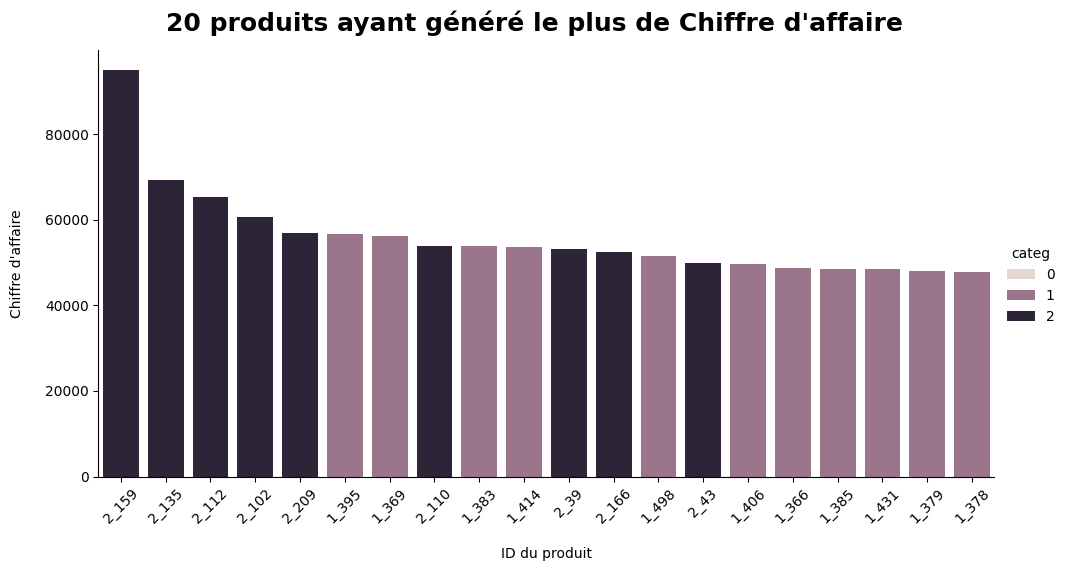

In [51]:
# TOP 20
top_20 = df_data.groupby(['id_prod', 'categ'])[['price']].sum()
top_20 = top_20.sort_values('price', ascending = False).head(20).reset_index()

#Visualisasion
categs = sorted(df_data['categ'].unique()) 
palette = {0: '#e9d4cf', 1: '#a06f8d', 2: '#2d223a'}
top_20 ['categ'] = pd.Categorical(top_20 ['categ'], categories=categs)

g = sns.catplot(data = top_20, x= 'id_prod', y = 'price', hue='categ', kind = 'bar', aspect= 2, palette = palette)
g.fig.suptitle("20 produits ayant généré le plus de Chiffre d'affaire", y= 1.05, fontsize=18, fontweight='bold')
g.ax.set_xlabel("ID du produit", labelpad=15)  
g.ax.set_ylabel("Chiffre d'affaire", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

**Courbe de Lorenz :**

In [52]:
# Préparation à la Courbe de Lorenz
Ca_par_client = df_data.groupby('client_id')[['price']].sum()
sorted_values = np.sort(Ca_par_client['price'].values)

# Cumul des valeurs
cumulative = np.cumsum(sorted_values)

# Normalisation
cumulative_percent = cumulative / cumulative[-1]  # cumulé / total
x = np.linspace(0.0, 1.0, len(cumulative_percent))

# Ajout de 0 au début pour la courbe
x = np.insert(x, 0, 0)
cumulative_percent = np.insert(cumulative_percent, 0, 0)

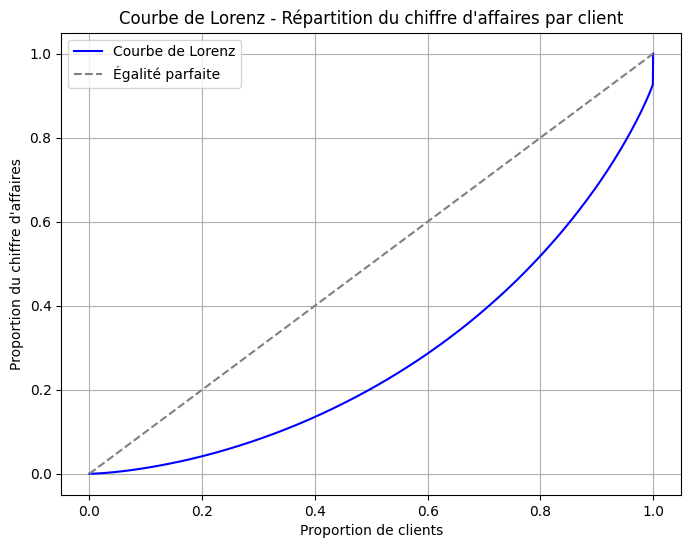

In [53]:
#Courbe de Lorenz
plt.figure(figsize=(8, 6))
plt.plot(x, cumulative_percent, label='Courbe de Lorenz', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Égalité parfaite')
plt.title("Courbe de Lorenz - Répartition du chiffre d'affaires par client")
plt.xlabel("Proportion de clients")
plt.ylabel("Proportion du chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Indice de GINI
gini = 1 - 2 * np.trapezoid(cumulative_percent, x)
print(f"Indice de Gini : {gini:.4f}")

Indice de Gini : 0.4418


**Inégalités modérées à fortes, Une minorité de clients génèrent une part significative du CA.**

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Tests d'Hypothèses</h2>
</div>

In [55]:
df_data.head()

,id_prod,price,categ,date,session_id,client_id,sex,birth,mois
0,0_1421,19.99,0,2021-03-01 04:13:00.107748,s_101,c_8533,m,1972,2021-03-01
1,0_1421,19.99,0,2021-03-01 13:48:20.214075,s_285,c_5299,f,1967,2021-03-01
2,0_1421,19.99,0,2021-03-01 15:07:42.730079,s_317,c_8024,f,1936,2021-03-01
3,0_1421,19.99,0,2021-03-02 03:39:21.811833,s_563,c_7702,f,1989,2021-03-01
4,0_1421,19.99,0,2021-03-02 19:09:41.789425,s_850,c_4057,m,1981,2021-03-01


**TEST 1 : lien entre le genre d’un client et les catégories des livres achetés.**

In [56]:
grouped = df_data.groupby(['categ', 'sex']).size().reset_index(name='compte')
grouped2 = df_data.groupby('categ').size().reset_index(name='total')
grouped2

,categ,total
0,0,415459
1,1,235592
2,2,36483


In [57]:
df_test_1 = grouped2.merge(grouped, on ='categ')
df_test_1['pourcent'] = df_test_1['compte'] / df_test_1['total'] * 100
df_test_1

,categ,total,sex,compte,pourcent
0,0,415459,f,206103,49.608505
1,0,415459,m,209356,50.391495
2,1,235592,f,119307,50.641363
3,1,235592,m,116285,49.358637
4,2,36483,f,17283,47.372749
5,2,36483,m,19200,52.627251


In [58]:
# Test
contingency_table = pd.crosstab(df_data['categ'], df_data['sex'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi² = {chi2}")
print(f"p-value = {p_value}")

Chi² = 158.25417617304882
p-value = 4.3205822283997063e-35


In [59]:
# TEST de proportion à deux échantillons
categories = df_test_1['categ'].unique()

for cat in sorted(categories):
    subset = df_test_1[df_test_1['categ'] == cat]
    
    # Extraire les succès et les nobs pour f et m
    successes = subset['compte'].tolist()
    nobs = subset['total'].tolist()
    
    z_score, pval = proportions_ztest(successes, nobs)
    
    print(f"\nCatégorie {cat}:")
    print(f"  - Proportion femmes : {successes[0] / nobs[0]:.2%}")
    print(f"  - Proportion hommes : {successes[1] / nobs[1]:.2%}")
    print(f"  - Z = {z_score:.4f}, p-value = {pval:.4f}")
    
    # Interprétation
    alpha = 0.05
    if pval < alpha:
        print(f"  →  Différence significative entre hommes et femmes (p < {alpha})")
    else:
        print(f"  →  Aucune différence significative (p ≥ {alpha})")


Catégorie 0:
  - Proportion femmes : 49.61%
  - Proportion hommes : 50.39%
  - Z = -7.1373, p-value = 0.0000
  →  Différence significative entre hommes et femmes (p < 0.05)

Catégorie 1:
  - Proportion femmes : 50.64%
  - Proportion hommes : 49.36%
  - Z = 8.8050, p-value = 0.0000
  →  Différence significative entre hommes et femmes (p < 0.05)

Catégorie 2:
  - Proportion femmes : 47.37%
  - Proportion hommes : 52.63%
  - Z = -14.1936, p-value = 0.0000
  →  Différence significative entre hommes et femmes (p < 0.05)


**Une différence statistiquement significative entre hommes et femmes est observée dans chacune des trois catégories.**

**TEST 2 : le lien entre l'âge des clients et le montant total des achats.**

In [60]:
# Création de la colonne 'âge'
df_data['âge'] = df_data['mois'].dt.year- df_data['birth']

In [61]:
test2a = df_data.groupby('client_id').agg({'âge': 'first', 'price': 'sum'}).reset_index()
test2a

,client_id,âge,price
0,c_1,66,629.02
1,c_10,65,1353.60
2,c_100,29,254.85
3,c_1000,55,2291.88
4,c_1001,39,1823.85
...,...,...,...
8595,c_995,66,189.41
8596,c_996,51,1637.34
8597,c_997,27,1490.01
8598,c_998,20,2822.22


In [62]:
#test2 = df_data.groupby('âge')[['price']].sum()

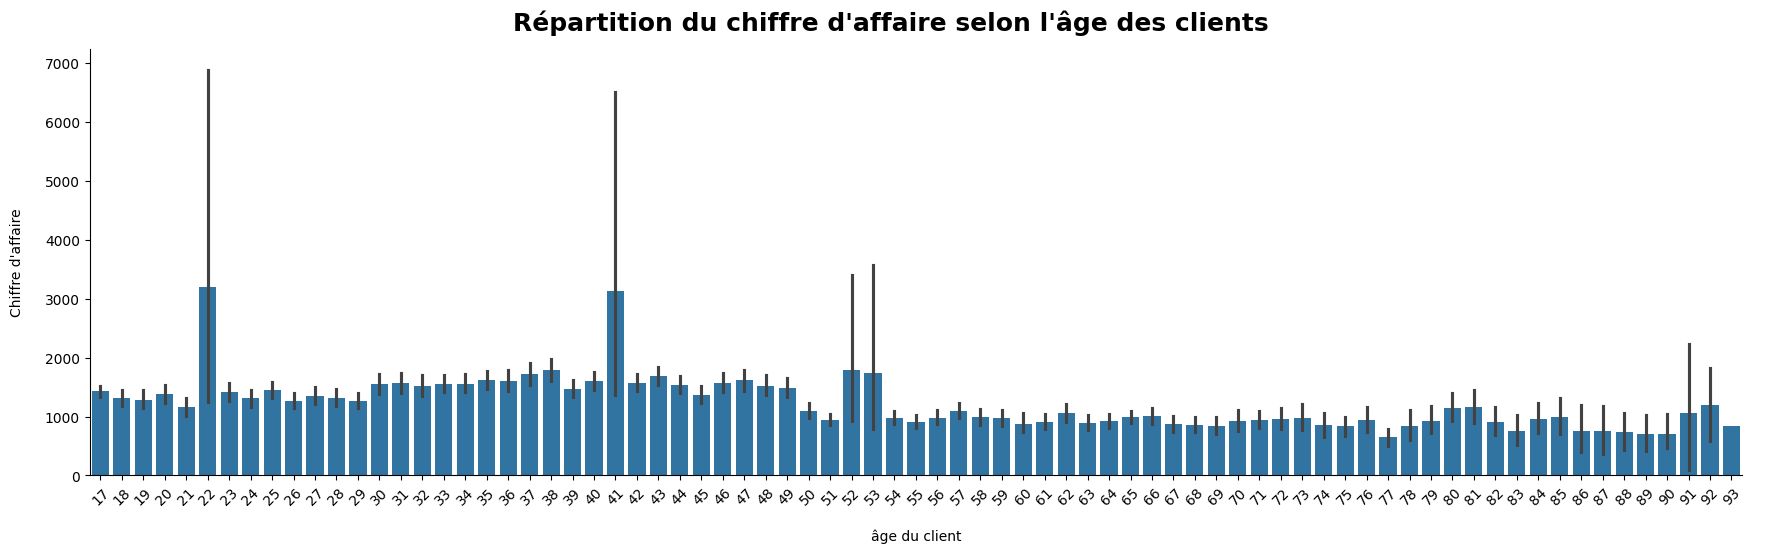

In [63]:
# Visualisation du test 2 

g = sns.catplot(data= test2a, x = "âge", y='price', kind='bar', aspect =3.5)
g.fig.suptitle("Répartition du chiffre d'affaire selon l'âge des clients", y= 1.05, fontsize=18, fontweight='bold')
g.ax.set_xlabel("âge du client", labelpad=15)  
g.ax.set_ylabel("Chiffre d'affaire", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

In [64]:
# Corrélation de Spearman (car données non normales)
rho, p_spearman = spearmanr(test2a['âge'], test2a['price'])
print(f"Corrélation de Spearman : rho = {rho:.3f}, p-value = {p_spearman:.3e}")

Corrélation de Spearman : rho = -0.184, p-value = 2.744e-66


**Hypothèse nulle rejetée → il y a bien une corrélation entre l'âge et le montant total des achats.
Relation négative modeste : les clients plus âgés ont tendance à dépenser légèrement moins.
Effet faible : ni ici ni dans un contexte métier, ce lien n’est très fort ou déterminant.**

**TEST 3 : le lien entre l'âge des clients et la fréquence d’achat.**

In [65]:
# Nombre total d’achats effectués par des clients d’un certain âge
test3 = df_data.groupby('âge').size().reset_index()
test3 = test3.rename(columns={0 : "compte"})

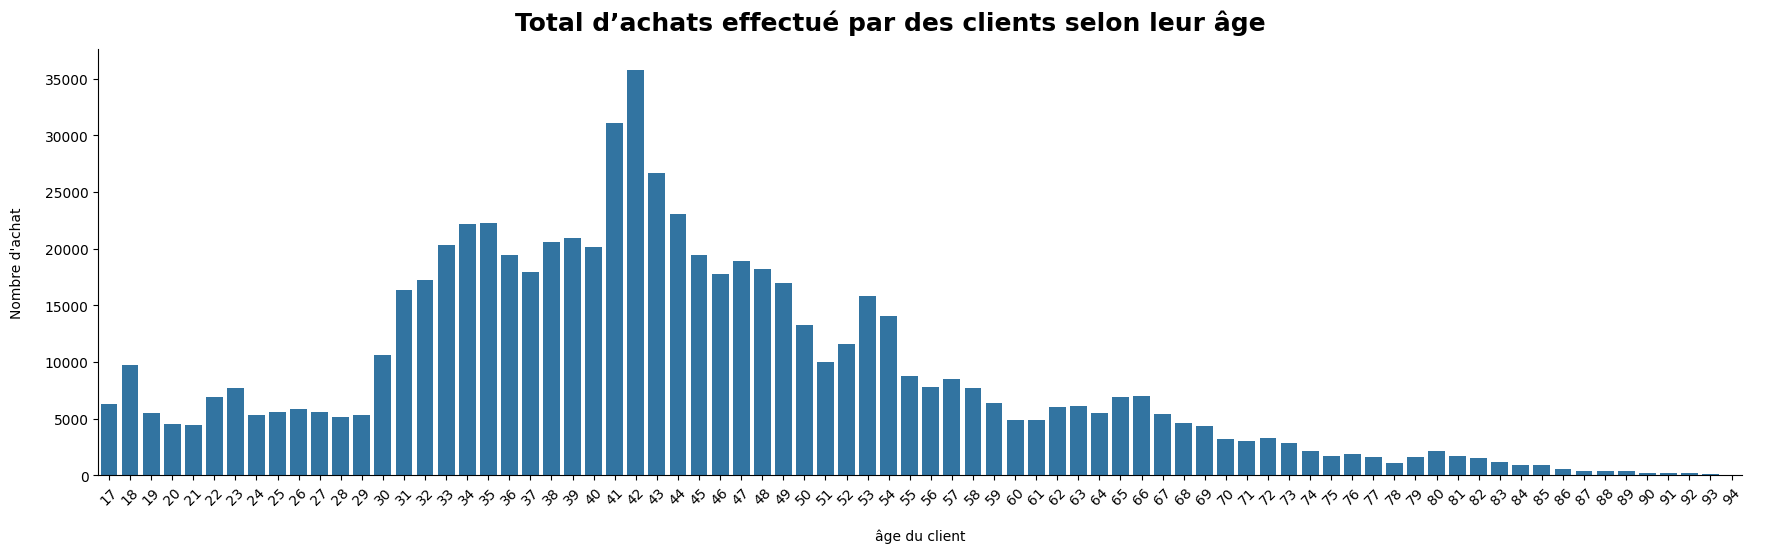

In [66]:
# Visualisation total d’achats effectués par des clients d’un certain âge
g = sns.catplot(data= test3, x = "âge", y='compte', kind='bar', aspect =3.5)
g.fig.suptitle("Total d’achats effectué par des clients selon leur âge", 
               y= 1.05, fontsize=18, fontweight='bold')
g.ax.set_xlabel("âge du client", labelpad=15)  
g.ax.set_ylabel("Nombre d'achat", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

In [67]:
# TEST3
correlation, p_value = pearsonr(test3['âge'], test3['compte'])

print(f"Coefficient de corrélation : {correlation}")
print(f"p-value : {p_value}")

Coefficient de corrélation : -0.5587224171239413
p-value : 1.0608439849387145e-07


**TEST 4 : le lien entre l'âge des clients et la taille du panier moyen.**

In [68]:
# Nombre de produit en moyenne par session
print(df_data.groupby('session_id').size().mean())

1.9899393641191878


In [69]:
# Regroupement par session : une ligne = une session
test4 = df_data.groupby('session_id').agg({'price': 'sum', 'âge': 'first'}).reset_index()
test4.rename(columns={'price': 'taille_panier'}, inplace=True)
test4

,session_id,taille_panier,âge
0,s_1,11.99,54
1,s_10,26.99,51
2,s_100,33.72,43
3,s_1000,39.22,32
4,s_10000,41.49,32
...,...,...,...
345500,s_99995,19.84,61
345501,s_99996,56.27,47
345502,s_99997,6.99,42
345503,s_99998,35.11,43


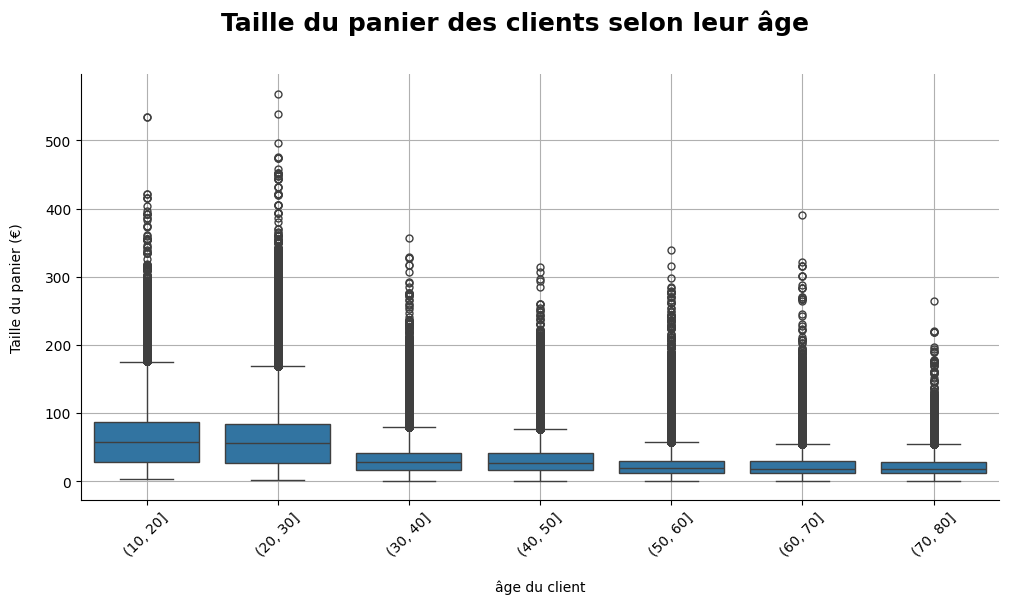

In [70]:
#Visualisation de la Taille du panier des clients selon leur âge
test4['tranche_âge'] = pd.cut(test4['âge'], bins=[10, 20, 30, 40, 50, 60, 70, 80])
g =sns.catplot(data = test4, x = 'tranche_âge', y='taille_panier', kind = 'box', aspect = 2)
g.fig.suptitle("Taille du panier des clients selon leur âge", 
               y= 1.1, fontsize=18, fontweight='bold')
g.ax.set_xlabel("âge du client", labelpad=15)  
g.ax.set_ylabel("Taille du panier (€)", labelpad=15) 
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [71]:
# Test par une Régression linéaire
new = ols("taille_panier~âge", data= test4).fit()
p_value = new.pvalues['âge']
coef_age = new.params['âge']
print(f"La p-value pour l'âge est : {p_value}")
print(f"Le coefficient pour l'âge est : {coef_age:.3f}")

La p-value pour l'âge est : 0.0
Le coefficient pour l'âge est : -0.714


**L'effet de l'âge est statistiquement significatif (p-value ≈ 0). Chaque année d'âge en plus est associée à une diminution moyenne de 0.714 € de la taille du panier.**

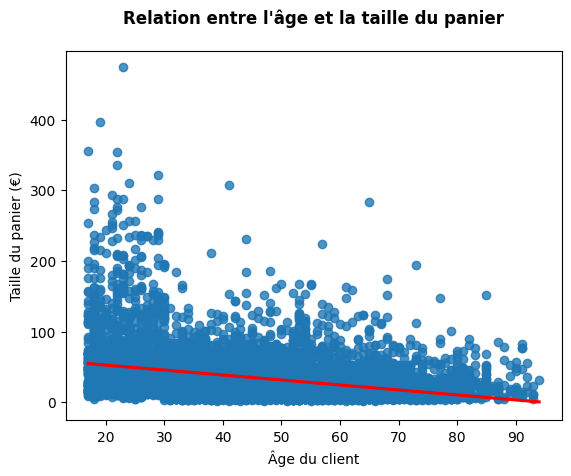

In [78]:
# Visualisation de la Régression linéaire
df_sample = test4.sample(n=10000, random_state=42)
sns.regplot(data=df_sample, x="âge", y="taille_panier", line_kws={"color": "red"})
plt.title("Relation entre l'âge et la taille du panier", y=1.05,  fontweight = 'bold')
plt.xlabel("Âge du client")
plt.ylabel("Taille du panier (€)")
plt.show()

**TEST 5 : le lien entre l'âge des clients et la catégorie des
livres achetés.**

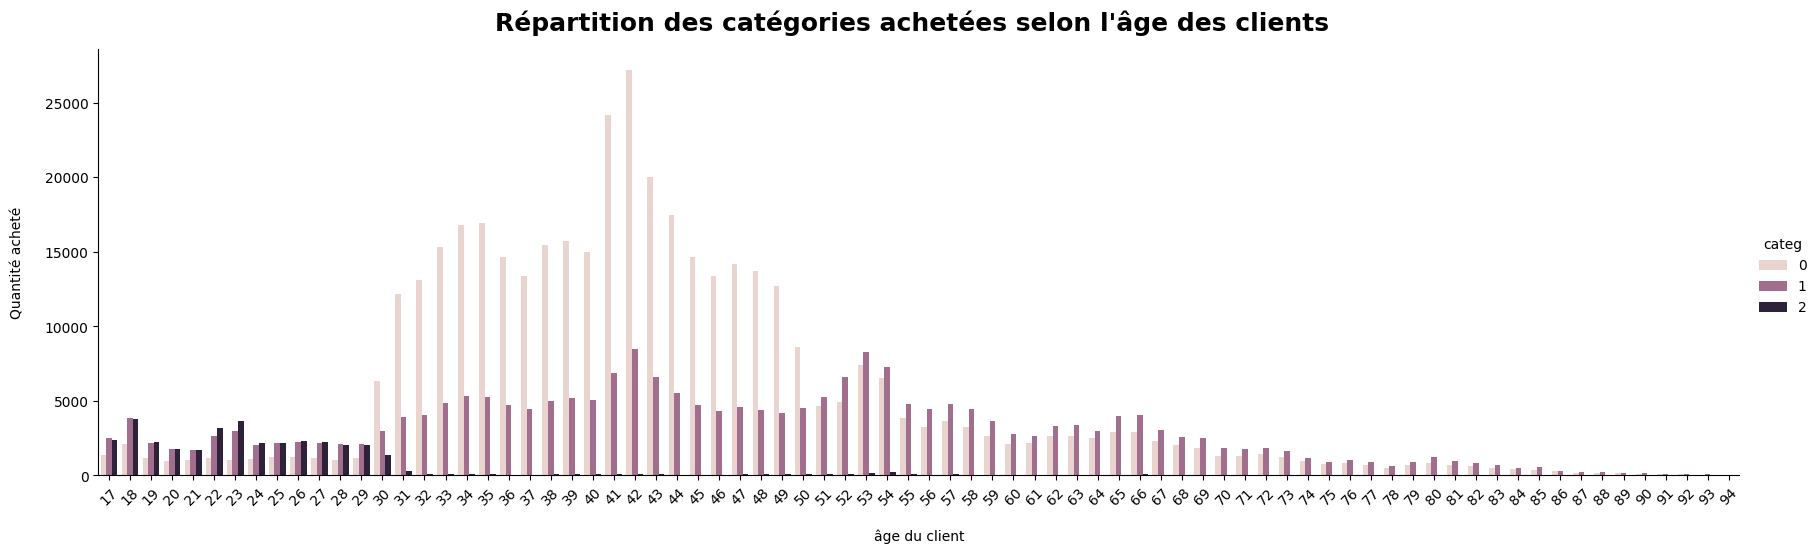

In [73]:
test5 = df_data.groupby(['âge', 'categ']).size().reset_index(name='compte')
g = sns.catplot(data= test5, x = "âge", y='compte', kind='bar', hue='categ', aspect =3.5)
g.fig.suptitle("Répartition des catégories achetées selon l'âge des clients", 
               y= 1.05, fontsize=18, fontweight='bold')
g.ax.set_xlabel("âge du client", labelpad=15)  
g.ax.set_ylabel("Quantité acheté", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

In [74]:
# Méthode avec pingouin
df_data['classe_âge'] = pd.cut(df_data['âge'], bins=range(0, 110, 10), right=False)
expected, observed, stats = pingouin.chi2_independence(data=df_data, x='classe_âge', y='categ')
print(stats)

                 test    lambda           chi2   dof  pval    cramer  power
0             pearson  1.000000  284989.315768  16.0   0.0  0.455252    1.0
1        cressie-read  0.666667  237788.341791  16.0   0.0  0.415847    1.0
2      log-likelihood  0.000000  194844.618855  16.0   0.0  0.376428    1.0
3       freeman-tukey -0.500000  191318.100609  16.0   0.0  0.373006    1.0
4  mod-log-likelihood -1.000000  209542.855474  16.0   0.0  0.390368    1.0
5              neyman -2.000000  373697.534698  16.0   0.0  0.521312    1.0


In [75]:
# Méthode avec chi2_contingency
test5.columns = ['âge', 'categ', 'count']  

# Création de la table de contingence
contingency_table = test5.pivot(index='âge', columns='categ', values='count').fillna(0)

# Application du test du khi²
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi² = {chi2:.2f}")
print(f"p-value = {p:.4f}")

Chi² = 292337.74
p-value = 0.0000


**Avec une p_value = 0, On obtient cette conclusion statistique : Il existe une association statistiquement significative entre l’âge et la catégorie de produit achetée.**